In [1]:
# Импорт библиотек

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, when, mean, median, min, max, length, round, count, struct, first, floor
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.window import Window

import requests
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Инициализируем SparkSession
spark = SparkSession.builder \
        .appName("Load CSV") \
        .master("local") \
        .getOrCreate()

## 1. Загрузите файл данных в DataFrame PySpark.

In [4]:
# Функция для скачивания файла
url = "https://aytomaximo.ru/share/russian_houses.csv"
response = requests.get(url)
with open("russian_houses.csv", "wb") as file:
        file.write(response.content)

In [5]:
# Чтение CSV-файла
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("encoding", "UTF-16") \
    .option('multiline', 'true') \
    .load("russian_houses.csv")

# Предпросмотр
df.show(5)

+--------+------------------+------------------+----------------+--------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|house_id|          latitude|         longitude|maintenance_year|  square|population|             region|       locality_name|             address|        full_address|communal_service_id|         description|
+--------+------------------+------------------+----------------+--------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|       1|         44.707617|         43.006476|            1974|2 661.10|        89|Ставропольский край|село Александровское|с. Александровско...|Ставропольский кр...|                1.0|Жилой дом в , по ...|
|       2|44.706720000000004|         43.005281|            1989|3 111.10|       115|Ставропольский край|село Александровское|с. Александровско...|Ставропольски

### Обязательно выведите количество строк.

In [6]:
print(df.count())

590707


## 2. Убедитесь, что данные корректно прочитаны (правильный формат, отсутствие пустых строк)

In [7]:
# Вывести схему для проверки типов данных
df.printSchema()

root
 |-- house_id: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- maintenance_year: string (nullable = true)
 |-- square: string (nullable = true)
 |-- population: string (nullable = true)
 |-- region: string (nullable = true)
 |-- locality_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- full_address: string (nullable = true)
 |-- communal_service_id: string (nullable = true)
 |-- description: string (nullable = true)



In [8]:
# Проверка на наличие пустых строк
empty_rows = df.filter(col(df.columns[0]).isNull())
print(f"Number of empty rows: {empty_rows.count()}")

# Проверка на наличие дубликатов строк
duplicates = df.groupBy(df.columns).count().filter("count > 1")
print(f"Number of duplicate rows: {duplicates.count()}")

Number of empty rows: 0
Number of duplicate rows: 0


## 3. Преобразуйте текстовые и числовые поля в соответствующие типы данных (например, дата, число).

In [9]:
# Преобразование maintenance_year в целое число, обработка NULL
df = df.withColumn("maintenance_year", when(col("maintenance_year").isNull(), None)
                                      .otherwise(col("maintenance_year").cast(IntegerType())))

In [10]:
# Вместо '-' использовать None и убрать пробелы из колонки 'квадрат'
df = df.withColumn("square", regexp_replace(col("square"), "—", "NULL"))
df = df.withColumn("square", regexp_replace(col("square"), " ", ""))

# Преобразование столбца 'square' в double, обработка NULL
df = df.withColumn("square", when(col("square") == "NULL", None)
                               .otherwise(col("square").cast(FloatType())))

In [11]:
# Вместо «-» в столбце `population` поставить None.
df = df.withColumn("population", regexp_replace(col("population"), "—", "NULL"))

# Преобразование столбца 'population' в double, обработка NULL
df = df.withColumn("population", when(col("population") == "NULL", None)
                               .otherwise(col("population").cast(IntegerType())))

In [12]:
# Преобразование communal_service_id в целое число, обработка пустых значений
df = df.withColumn("communal_service_id", when(col("communal_service_id") == "", None)
                                      .otherwise(col("communal_service_id").cast(IntegerType())))

In [13]:
df.show(5)
df.printSchema()

+--------+------------------+------------------+----------------+-------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|house_id|          latitude|         longitude|maintenance_year| square|population|             region|       locality_name|             address|        full_address|communal_service_id|         description|
+--------+------------------+------------------+----------------+-------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|       1|         44.707617|         43.006476|            1974| 2661.1|        89|Ставропольский край|село Александровское|с. Александровско...|Ставропольский кр...|                  1|Жилой дом в , по ...|
|       2|44.706720000000004|         43.005281|            1989| 3111.1|       115|Ставропольский край|село Александровское|с. Александровско...|Ставропольский кр.

## 4. Вычислите средний и медианный год постройки зданий.

In [14]:
current_year = datetime.now().year

# Отфильтруем реалистичные значения годов постройки
df = df.filter((col("maintenance_year") < current_year) & (col("maintenance_year") > 1000))

In [15]:
# Рассчитаем среднее и медиану для 'maintenance_year'
mean_maintenance_year = df.select(round(mean("maintenance_year"), 0)).collect()[0][0]
median_maintenance_year = df.select(round(median("maintenance_year"), 0)).collect()[0][0]

print(f"Mean maintenance year: {mean_maintenance_year}")
print(f"Median maintenance year: {median_maintenance_year}")

Mean maintenance year: 1970.0
Median maintenance year: 1970.0


## 5. Определите топ-10 областей и городов с наибольшим количеством объектов.

In [16]:
# Сгруппируем по регионам, затем подсчитаем количество объектов
top_regions = df.groupBy("region").count().orderBy("count", ascending=False)

# Демонстрация
top_regions.show(10)

+--------------------+-----+
|              region|count|
+--------------------+-----+
|  Московская область|30187|
|Свердловская область|27235|
|              Москва|24731|
|Нижегородская обл...|18020|
|Республика Татарстан|14400|
|   Красноярский край|14353|
| Кемеровская область|13290|
|   Самарская область|13046|
|  Ростовская область|12040|
|   Иркутская область|11984|
+--------------------+-----+
only showing top 10 rows



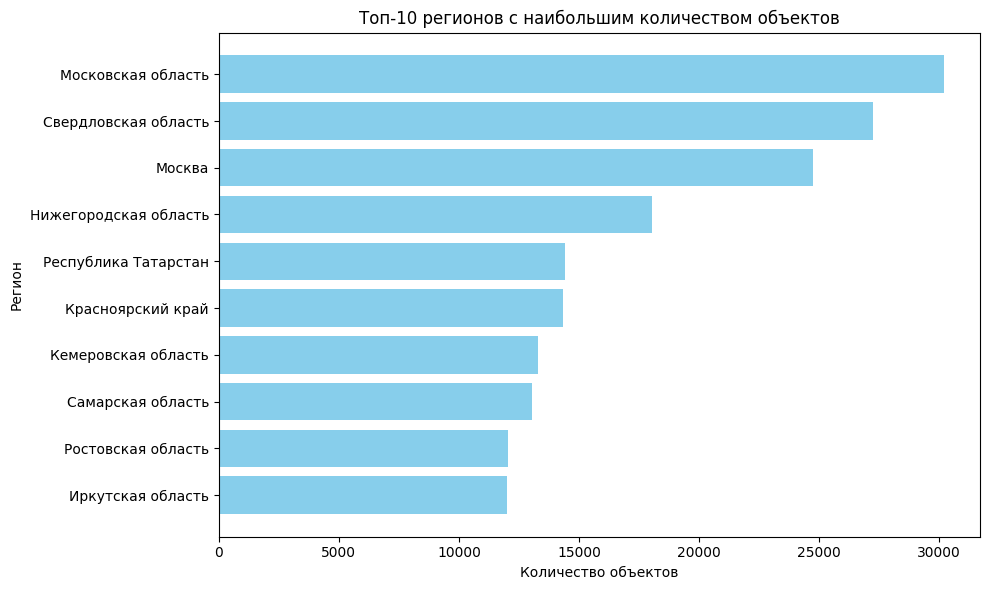

In [17]:
# Преобразуем PySpark DataFrame в pandas DataFrame
top_regions_pd = top_regions.limit(10).toPandas()

# Данные для графика
regions = top_regions_pd['region']
counts = top_regions_pd['count']

# Построение линейчатого графика
plt.figure(figsize=(10, 6))
plt.barh(regions, counts, color='skyblue')  # Горизонтальные линии

# Добавляем подписи и заголовок
plt.xlabel('Количество объектов')
plt.ylabel('Регион')
plt.title('Топ-10 регионов с наибольшим количеством объектов')

# Инвертируем ось Y, чтобы регионы с наибольшим количеством были сверху
plt.gca().invert_yaxis()

# Показываем график
plt.tight_layout()
plt.show()

In [18]:
# Сгруппируем объекты по местоположению, затем подсчитаем их количество
top_locations = df.groupBy("locality_name").count().orderBy("count", ascending=False)

# Демонстрация
top_locations.show(10)

+---------------+-----+
|  locality_name|count|
+---------------+-----+
|         Москва|24631|
|         Самара| 6941|
|   Екатеринбург| 6825|
|Санкт-Петербург| 6112|
|Нижний Новгород| 5899|
|    Новосибирск| 5441|
|     Красноярск| 5299|
| Ростов-на-Дону| 5132|
|         Казань| 4896|
|           NULL| 4892|
+---------------+-----+
only showing top 10 rows



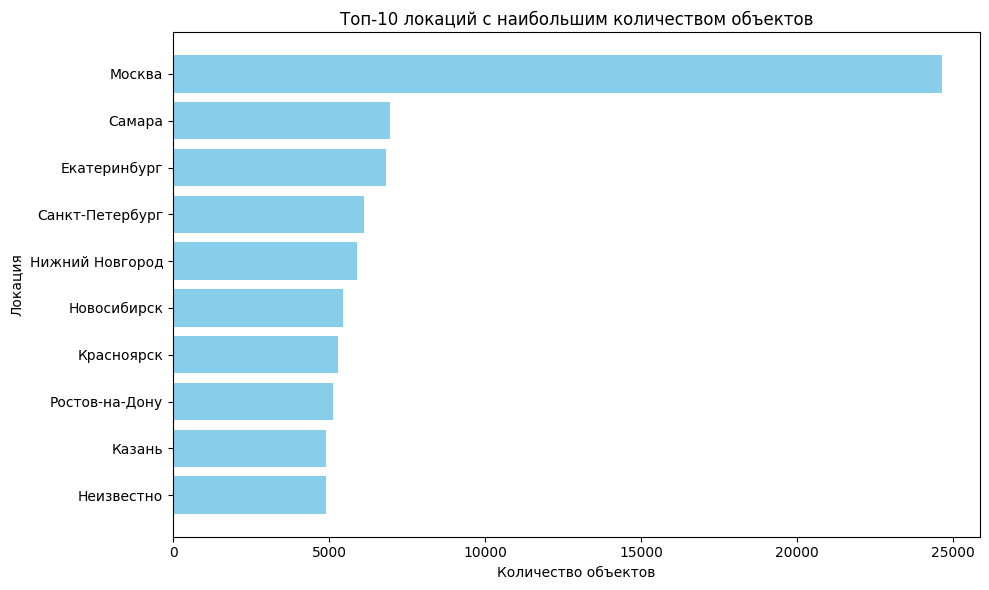

In [19]:
# Заменяем NULL значения в locality_name на "Неизвестно"
top_locations_cleaned = top_locations.withColumn(
    "locality_name", when(col("locality_name").isNull(), "Неизвестно").otherwise(col("locality_name"))
)

# Преобразуем PySpark DataFrame в pandas DataFrame
top_locations_pd = top_locations_cleaned.limit(10).toPandas()

# Данные для графика
localities = top_locations_pd['locality_name']
counts = top_locations_pd['count']

# Построение линейчатого графика
plt.figure(figsize=(10, 6))
plt.barh(localities, counts, color='skyblue')  # Горизонтальные линии

# Добавляем подписи и заголовок
plt.xlabel('Количество объектов')
plt.ylabel('Локация')
plt.title('Топ-10 локаций с наибольшим количеством объектов')

# Инвертируем ось Y, чтобы локации с наибольшим количеством были сверху
plt.gca().invert_yaxis()

# Показываем график
plt.tight_layout()
plt.show()

## 6. Найдите здания с максимальной и минимальной площадью в рамках каждой области.

In [20]:
# Убираем NULL значения из колонки square
filtered_df = df.filter(col("square").isNotNull())

# Оконные функции для минимального и максимального значений square
window_spec_min = Window.partitionBy("region").orderBy("square")
window_spec_max = Window.partitionBy("region").orderBy(col("square").desc())

# Находим минимальные значения площади и соответствующие адреса
min_df = (
    filtered_df
    .withColumn("min_address", first("address").over(window_spec_min))
    .withColumn("min_square", first("square").over(window_spec_min))
    .groupBy("region")
    .agg(
        first("min_address").alias("min_address"),
        first("min_square").alias("min_square")
    )
)

# Находим максимальные значения площади и соответствующие адреса
max_df = (
    filtered_df
    .withColumn("max_address", first("address").over(window_spec_max))
    .withColumn("max_square", first("square").over(window_spec_max))
    .groupBy("region")
    .agg(
        first("max_address").alias("max_address"),
        first("max_square").alias("max_square")
    )
)

# Объединяем результаты
result_df = min_df.join(max_df, on="region")

# Выводим результат
result_df.show()

+--------------------+--------------------+----------+--------------------+----------+
|              region|         min_address|min_square|         max_address|max_square|
+--------------------+--------------------+----------+--------------------+----------+
|              Алматы|д. г Навашино ул ...|    457.08|ул. Орджоникидзе,...|    3403.0|
|      Алтайский край| ул. Витебская, д. 2|      3.26|ул. Папанинцев, д...|   88871.7|
|    Амурская область|пер. Кооперативны...|      26.6|пгт. Февральск, у...|  429720.0|
|Архангельская обл...|п. Илеза, ул. Пер...|       1.0|пр-кт. Московский...|   39452.7|
|Астраханская область|ул. Лиманская, д....|      55.9|ул. С.Перовской, ...|   15026.0|
|Белгородская область|   ул. Разина, д. 10|      16.3|мкр. Макаренко, д...|  41918.63|
|    Брянская область| ул. Почтовая, д. 48|      18.8|ул. Красноармейск...|   40764.3|
|Владимирская область|  ул. Чапаева, д. 1Б|      3.01|пр-кт. Октябрьски...|   26959.0|
|Волгоградская обл...|ул. им Циолковско...|

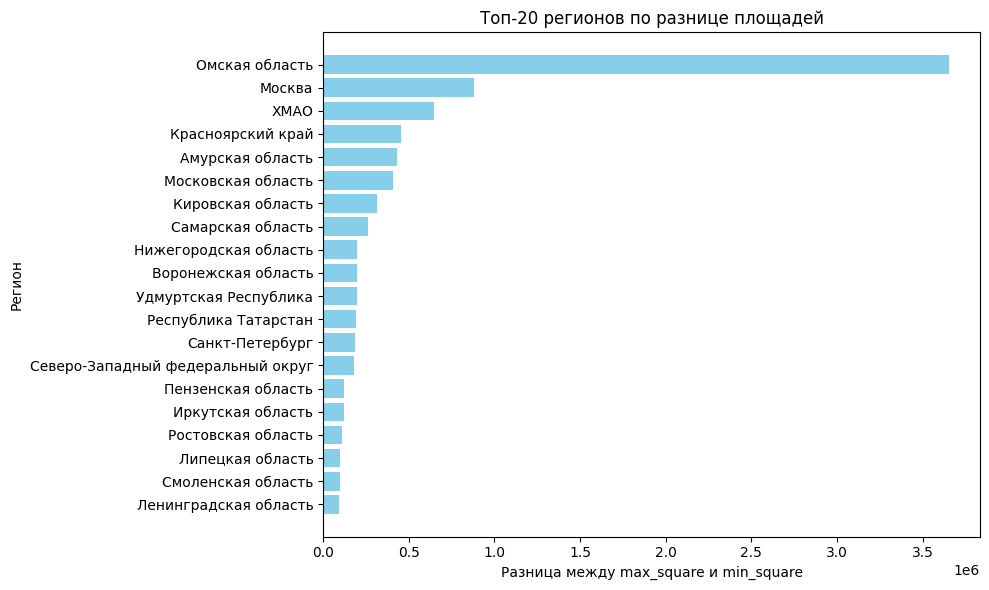

In [21]:
# Преобразуем PySpark DataFrame в pandas DataFrame
df_pd = result_df.toPandas()

# Добавляем колонку с разницей между max_square и min_square
df_pd['square_difference'] = df_pd['max_square'] - df_pd['min_square']

# Сортируем по разнице и берём топ-20
top_regions = df_pd.sort_values(by='square_difference', ascending=False).head(20)

# Данные для графика
regions = top_regions['region']
differences = top_regions['square_difference']

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(regions, differences, color='skyblue')

# Настройка графика
plt.xlabel('Разница между max_square и min_square')
plt.ylabel('Регион')
plt.title('Топ-20 регионов по разнице площадей')
plt.gca().invert_yaxis()
plt.tight_layout()

# Показываем график
plt.show()

## 7. Определите количество зданий по десятилетиям (например, сколько зданий построено в 1950-х, 1960-х и т.д.).

In [22]:
# Убираем NULL значения из maintenance_year
filtered_df = df.filter(col("maintenance_year").isNotNull())

# Добавляем колонку "decade" для десятилетия
df_with_decade = filtered_df.withColumn(
    "decade",
    (floor(col("maintenance_year") / 10) * 10).cast("int")  # Определяем десятилетие
)

# Группируем по десятилетию и считаем количество зданий
buildings_by_decade = (
    df_with_decade.groupBy("decade")
    .agg(count("*").alias("building_count"))
    .orderBy("decade" , ascending=False) # Сортируем по десятилетию
)

# Выводим результат
buildings_by_decade.show()

+------+--------------+
|decade|building_count|
+------+--------------+
|  2010|         13860|
|  2000|         23054|
|  1990|         42381|
|  1980|         89893|
|  1970|         96316|
|  1960|        110261|
|  1950|         83461|
|  1940|         18745|
|  1930|         12596|
|  1920|          4830|
|  1910|         13853|
|  1900|          2643|
|  1890|          1205|
|  1880|           698|
|  1870|           380|
|  1860|           189|
|  1850|           129|
|  1840|            72|
|  1830|            69|
|  1820|            48|
+------+--------------+
only showing top 20 rows



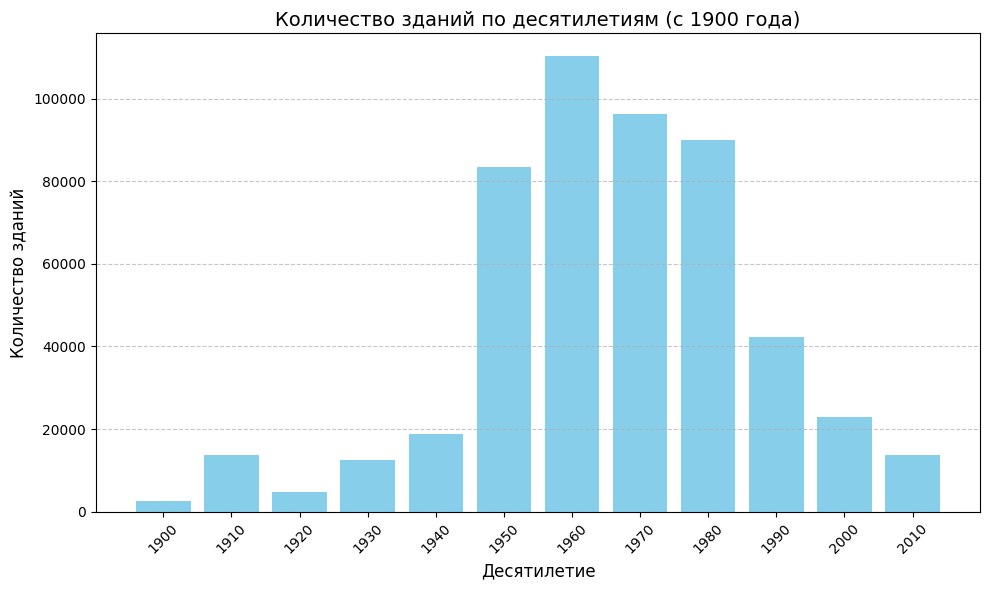

In [23]:
# Преобразуем PySpark DataFrame в pandas DataFrame
decades_pd = buildings_by_decade.toPandas()

# Фильтруем данные: оставляем только десятилетия >= 1900
filtered_decades = decades_pd[decades_pd['decade'] >= 1900]

# Сортируем данные по десятилетиям
filtered_decades = filtered_decades.sort_values(by='decade')

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(filtered_decades['decade'], filtered_decades['building_count'], color='skyblue', width=8)

# Настройка графика
plt.xlabel('Десятилетие', fontsize=12)
plt.ylabel('Количество зданий', fontsize=12)
plt.title('Количество зданий по десятилетиям (с 1900 года)', fontsize=14)
plt.xticks(filtered_decades['decade'], rotation=45)  # Поворачиваем подписи
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показываем график
plt.tight_layout()
plt.show()